In [1]:
import numpy as np
import matplotlib.pyplot as plt

### LIF neuron w/ an electrode recording

In [2]:
# Give values to measured units
mV = 1e-3
nF = 1e-9
ms = 1e-3  # These units also function as dt
nA = 1e-9
bigMOhm = 1e6

# Other model parameters
g_max = 0.15  # Maximum conductance of synapses when all ion channels are open
p_max = 0.5   # Maximum probability that ion channels are open

In [3]:
class LIFNeuron:
    def __init__(self, I=0*nA, R=10*bigMOhm, V0=-60*mV, Vth=-50*mV, Vr=-65*mV, Vrest=-75*mV, tau=10*ms):
        # Set the parameters of the LIF neuron
        self.I = I                   # Input current
        self.R = R                   # Membrane resistance
        self.Vth = Vth               # Membrane potential threshold value
        self.Vr = Vr                 # Membrane potential reset value
        self.Vrest = Vrest           # Resting membrane potential / leaky reversal potential
        self.tau = tau               # Time constant
        
        self.V = V0                  # Initial membrane potential
        self.t_last_spike = -np.inf  # Time since last spike (initialised to a large negative value)
        self.n_spikes = 0            # Number of spikes (initialised to 0)
    
    def update(self):
        # Depolarize after spike
        if self.V == 0.0:
            self.V = self.Vr
            
        # Update the membrane potential
        Vtarget = self.Vrest - self.V + self.I*self.R  # Target membrane potential
        dV = (Vtarget/self.tau)*ms                     # Compute the change in membrane potential
        self.V += dV                                   # Update the membrane potential
            
        # Check if the neuron has spiked
        if self.V >= self.Vth:
            self.V = 0.0      

In [4]:
class electrode:
    def __init__(self, I=None):
        self.I = I             # Initialize the electrode with a constant input current
        self.outSynapses = {}  # Initialize a dictionary to store the outgoing synapses

    def connect(self, neuron, weight=1.0):
        self.outSynapses[neuron] = weight  # Connect the electrode to a neuron with a given weight

    def simulate(self, t):
        recording = []  # Record the output of the electrode i.e., membrane potential
        for t_ in t:
            # For each connected neuron, update the potential using the electrode's output
            for neuron, weight in self.outSynapses.items():
                neuron.I = self.output() * weight                

                neuron.update()
                recording.append(neuron.V)
                
        return recording

    def output(self):
        return self.I + np.random.normal(0,nA)

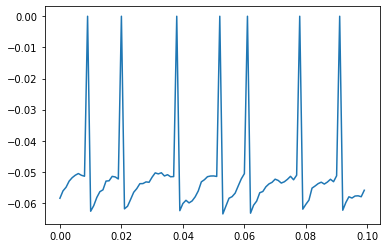

In [5]:
# Create an instance of the LIFNeuron class
lif_neuron = LIFNeuron()

# Set the time step and the time range
t = np.arange(0, 0.1, ms)

elec = electrode(I=3.1*nA)
elec.connect(lif_neuron)
potentials = elec.simulate(t)


plt.plot(t, potentials)
plt.show()

### LIF neurons w/ synapse

In [84]:
class LIFNeuron:
    def __init__(self, I=0*nA, R=10*bigMOhm, V0=-60*mV, Vth=-54*mV, Vr=-80*mV, Vleak=-70*mV, 
                 Vsyn=0*mV, tau_m=20*ms, tau_s=10*ms, leaky=True, excitatory=True):
        # Set the parameters of the LIF neuron
        self.I = I                   # Input current
        self.R = R                   # Membrane resistance
        self.Vth = Vth               # Membrane potential threshold value
        self.Vr = Vr                 # Membrane potential reset value
        self.Vleak = Vleak           # Resting membrane potential / leaky reversal potential
        self.Vsyn = Vsyn             # Synaptic reversal potential
        self.tau_m = tau_m           # Membrane time constant
        self.tau_s = tau_s           # Synaptic time constant
        
        self.V = V0                  # Initial membrane potential
        self.t_last_spike = 10*ms    # Time since last spike (initialised randomly)
        self.n_spikes = 0            # Number of spikes (initialised to 0)
        self.pOpenChannel = 0.0      # P(ion channels are open at the synapse)
        
        if not leaky:
            self.Vleak = 0
        if not excitatory:
            self.Vsyn = -80*mV
    
    def update(self):
        '''Updates the LIF neuron's state for a single time step'''
        self._hyperpolarize()
        self._updatePOpenChannel()
        self._updatePotential()
        self._depolarize()
        
        self.t_last_spike += 1.0*ms
    
    def _updatePotential(self):
        '''Update LIF neuron's membrane potential'''
        V_L = self.V - self.Vleak
        V_S = self.V - self.Vsyn
        g_s = g_max * self.pOpenChannel
        Vtarget = -g_s * V_S - V_L + self.I*self.R
        dV = (Vtarget/self.tau_m)*ms                # Compute the change in membrane potential
        self.V += dV                                # Update the membrane potential
        
    def _updatePOpenChannel(self):
        '''Update probability that ion channels are open at the synapse'''
        self.pOpenChannel =  p_max / self.tau_s * self.t_last_spike * np.exp(1.0 - self.t_last_spike / self.tau_s)

    def _hyperpolarize(self):
        '''Set membrane potential to the reset value if an action potential has just been fired'''
        if self.V == 0.0:
            self.V = self.Vr

    def _depolarize(self):
        '''Set membrane potential to 0 if an action potential has been fired'''
        if self.V >= self.Vth:
            self.V = 0.0
            
    def receiveActionPotential(self):
        '''Reset time since the last spike to 0 once an action potential has been fired'''
        self.t_last_spike = 0*ms

In [85]:
# Create an instance of the LIFNeuron class
lif_neurons = [LIFNeuron(I=0*nA, R=10*bigMOhm, V0=-60*mV, Vth=-54*mV, Vr=-80*mV, Vleak=-70*mV, Vsyn=0*mV,
                        tau_m=20*ms, tau_s=10*ms, leaky=True, excitatory=False) for _ in range(2)]

# Set the time step and the time range
t = np.arange(0, 1, ms)

potentials = [[], []]

# Iterate over the time range
for t_ in t:
    for i, neuron in enumerate(lif_neurons):
        lif_neurons[0].I = 1.8*nA
        if t_ > 8*ms:
            lif_neurons[1].I = 1.8*nA


        neuron.update()

        if neuron.V == 0.0:
            lif_neurons[1 - i].receiveActionPotential()

        potentials[i].append(neuron.V)

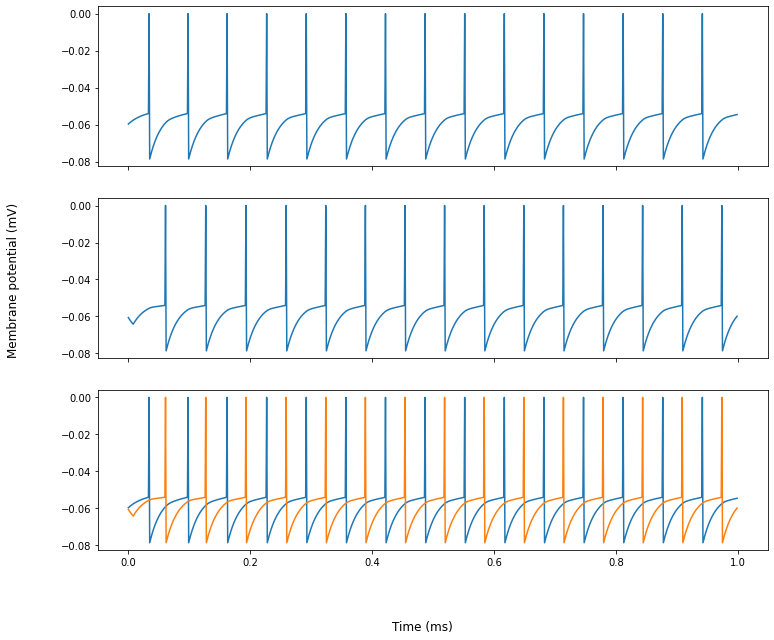

In [86]:
# Plot memebrane potentials of both neurons over time 
fig,ax = plt.subplots(3,1, figsize=(12, 10), sharex=True)

ax[0].plot(t, potentials[0])
ax[1].plot(t, potentials[1])
ax[2].plot(t, potentials[0])
ax[2].plot(t, potentials[1])

fig.supxlabel('Time (ms)')
fig.supylabel('Membrane potential (mV)')

plt.show()

### LIF neurons w/ excitatory and inhibitory synapses

In [87]:
class LIFNeuron:
    def __init__(self, I=0*nA, R=10*bigMOhm, V0=-60*mV, Vth=-54*mV, Vr=-80*mV, Vleak=-70*mV, 
                 Vsyn_ex=0*mV, Vsyn_in=-80*mV, tau_m=20*ms, tau_s=10*ms):
        # Set the parameters of the LIF neuron
        self.I = I                     # Synaptic current
        self.R = R                     # Membrane resistance
        self.Vth = Vth                 # Membrane potential threshold value
        self.Vr = Vr                   # Membrane potential reset value
        self.Vleak = Vleak             # Resting membrane potential / leaky reversal potential
        self.Vsyn_ex = Vsyn_ex         # Excitatory synaptic reversal potential
        self.Vsyn_in = Vsyn_in         # Inhibitory synaptic reversal potential
        self.tau_m = tau_m             # Membrane time constant
        self.tau_s = tau_s             # Synaptic time constant
        
        self.V = V0                    # Initial membrane potential
        self.t_last_spike_ex = 100*ms  # Time since last excitatory spike
        self.t_last_spike_in = 100*ms  # Time since last inhibitory spike
        
        self.n_spikes = 0              # Number of spikes (initialised to 0)
        self.pOpenExChannel = 0.0      # P(excitatory ion (Na+) channels are open at the synapse)
        self.pOpenInChannel = 0.0      # P(inhibitory ion (Cl-) channels are open at the synapse)
        
        self.synapses = {"excitatory": [], "inhibitory": []}
    
    def update(self):
        '''Updates the LIF neuron's state for a single time step'''
        self._hyperpolarize()
        self._updatePOpenExChannel()
        self._updatePOpenInChannel()
        self._updatePotential()
        self._depolarize()
        
        self.t_last_spike_ex += 1.0*ms
        self.t_last_spike_in += 1.0*ms
    
    def _updatePotential(self):
        '''Update LIF neuron's membrane potential'''
        V_L = self.V - self.Vleak
        V_S_ex = self.V - self.Vsyn_ex
        V_S_in = self.V - self.Vsyn_in
        g_s_ex = g_max * self.pOpenExChannel
        g_s_in = g_max * self.pOpenInChannel
        
        Vtarget = -g_s_ex * V_S_ex - g_s_in * V_S_in - V_L + self.I*self.R
        dV = (Vtarget/self.tau_m)*ms                # Compute the change in membrane potential
        self.V += dV                                # Update the membrane potential
        
    def _updatePOpenExChannel(self):
        '''Update probability that excitatory ion channels are open at the synapse'''
        self.pOpenExChannel =  p_max / self.tau_s * self.t_last_spike_ex * np.exp(1.0 - self.t_last_spike_ex / self.tau_s)
#         self.pOpenExChannel = - self.pOpenExChannel / self.tau_s * ms
        if self.t_last_spike_ex == 0.0:
            self.pOpenExChannel += p_max
            
    def _updatePOpenInChannel(self):
        '''Update probability that inhibitory ion channels are open at the synapse'''
        self.pOpenInChannel =  p_max / self.tau_s * self.t_last_spike_in * np.exp(1.0 - self.t_last_spike_in / self.tau_s)
#         self.pOpenInChannel = - self.pOpenInChannel / self.tau_s * ms
        if self.t_last_spike_in == 0.0:
            self.pOpenInChannel += p_max
            
    def _hyperpolarize(self):
        '''Set membrane potential to the reset value if an action potential has just been fired'''
        if self.V == 0.0:
            self.V = self.Vr

    def _depolarize(self):
        '''Set membrane potential to 0 if an action potential has been fired'''
        if self.V >= self.Vth:
            self.V = 0.0
            self._sendSpikes()
    
    def _sendSpikes(self):
        '''Send action potential to excite and inhibit other neurons in the network'''
        for neuron in self.synapses["excitatory"]:
            neuron.receiveActionPotential("excitatory")

        for neuron in self.synapses["inhibitory"]:
            neuron.receiveActionPotential("inhibitory")
            
    def receiveActionPotential(self, kind):
        '''Reset time since the last spike to 0 once an action potential has been fired'''
        if kind == "excitatory":
            self.t_last_spike_ex = 0*ms

        if kind == "inhibitory":
            self.t_last_spike_in = 0*ms

In [88]:
# Number of neurons in the network
n = 2

# Create an instance of the LIFNeuron class
lif_neurons = [LIFNeuron(I=0*nA, R=10*bigMOhm, V0=-60*mV, Vth=-54*mV, Vr=-80*mV, Vleak=-70*mV, 
                         Vsyn_ex=0*mV, Vsyn_in=-80*mV, tau_m=20*ms, tau_s=10*ms) for _ in range(n)]

# Set the time step and the time range
t = np.arange(0, 1, ms)

lif_neurons[0].synapses["inhibitory"].append(lif_neurons[1])
lif_neurons[1].synapses["excitatory"].append(lif_neurons[0])

potentials = [[] for _ in range(n)]
synapticVoltages = [[] for _ in range(n)]

# Iterate over the time range
for t_ in t:
    for i, neuron in enumerate(lif_neurons):
        if t_ == 0:
            lif_neurons[0].I = 1.8 * nA 
            lif_neurons[1].I = 1.8 * nA

        neuron.update()

        potentials[i].append(neuron.V)
        synapticVoltages[i].append(-g_max * neuron.pOpenExChannel * (neuron.V - neuron.Vsyn_ex)
                                   - g_max * neuron.pOpenInChannel * (neuron.V - neuron.Vsyn_in))

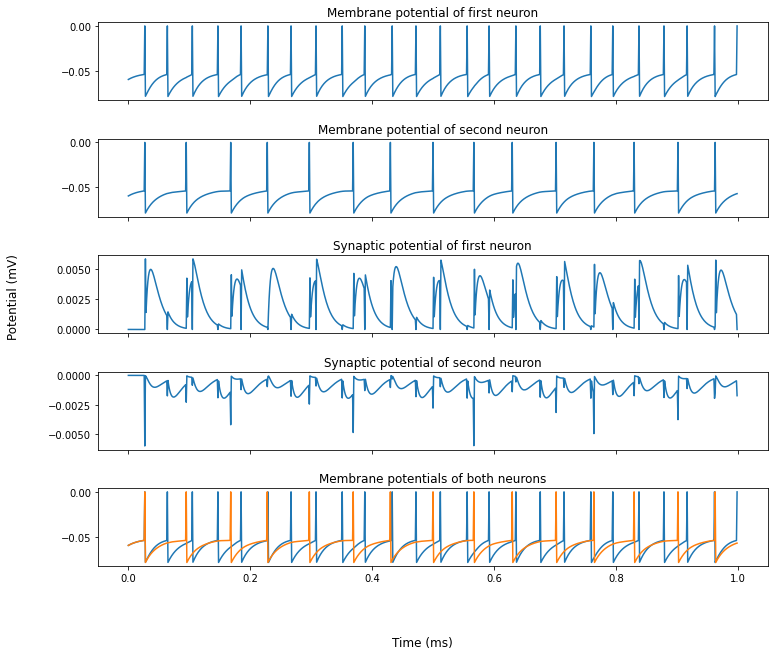

In [89]:
# Plot memebrane potentials and synaptic potentials of both neurons over time 
fig,ax = plt.subplots(5,1, figsize=(12, 10), sharex=True)
plt.subplots_adjust(hspace=0.50)

ax[0].plot(t, potentials[0])
ax[1].plot(t, potentials[1])
ax[2].plot(t, synapticVoltages[0])
ax[3].plot(t, synapticVoltages[1])
ax[4].plot(t, potentials[0])
ax[4].plot(t, potentials[1])

ax[0].set_title("Membrane potential of first neuron")
ax[1].set_title("Membrane potential of second neuron")
ax[2].set_title("Synaptic potential of first neuron")
ax[3].set_title("Synaptic potential of second neuron")
ax[4].set_title("Membrane potentials of both neurons")

fig.supxlabel('Time (ms)')
fig.supylabel('Potential (mV)')

plt.show()